# Regularisation – ridge

This notebook takes an in-depth look at regularisation and its implementation using the ridge regression method.

## Regularisation in 5 minutes

Regularisation is like having a magic wand to make our predictions better in a smarter way. 

Imagine we're baking a cake and we have a bunch of ingredients. Each ingredient (like flour, eggs, sugar) affects how the cake turns out. Similarly, in making predictions, we have different factors, or "ingredients", that affect our predictions.

Now, think of each ingredient as having its own importance level. For instance, in baking, maybe we need more flour than sugar. Similarly, in predicting, some factors might be more important than others.

In the past, we used to pick and choose which ingredients to use in our recipes. But with regularisation, we keep all the ingredients but adjust their amounts based on how important they are.

Let's take a look at our recipe, or equation, for making predictions:

$$RSS = \sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2$$

This might look like a complicated recipe, but it's just a way of saying, "Let's see how well our predictions match up with reality."

Now, here's the cool part. Regularisation adds a little twist to our recipe. It says, "Hey, let's not let any ingredient (or factor) get too big." Why? Because when one ingredient becomes too dominant, it can mess up the taste of our cake (or the accuracy of our predictions).

So, we add a new rule to our recipe:

$$\sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2 + \alpha\sum_{j=1}^pb_j^2$$

The new part, $\alpha\sum_{j=1}^pb_j^2$, is like a secret sauce that helps us control the quantities of our ingredients. The $\alpha$ is like a knob we can turn to decide how much we want to control the sizes.

Imagine $\alpha$ as the volume control on your music player. If you turn it up, it makes the ingredients smaller. If you turn it down, it lets them be bigger.

This secret sauce helps us balance two things: making sure our predictions fit the real data well, but also making sure none of our ingredients (or factors) become too overwhelming.

![tradeoff](https://raw.githubusercontent.com/Explore-AI/Pictures/master/tradeoff.png)

## Getting started

To begin, let's import a few Python libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next we'll load our data as a Pandas DataFrame.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/SDG_15_Life_on_Land_Dataset.csv', index_col=0)
df.head()

,WaterQualityIndex,ClimateChangeImpactScore,LandUseChange,InvasiveSpeciesCount,ConservationFunding,EcoTourismImpact,ForestCoverChange,SoilQualityIndex,WaterUsage,RenewableEnergyUsage,CarbonEmissionLevels,AgriculturalIntensity,HabitatConnectivity,SpeciesReintroductionEfforts,PollinatorDiversity,BiodiversityHealthIndex
Year,,,,,,,,,,,,,,,,
2010,35,7.542535,6.630073,39,46,1.193810,0.032204,70,33,13,22,1.419332,1.671324,9.311312,0.270434,0.194332
2010,13,1.617642,6.477132,45,18,8.484718,-4.803485,69,67,57,63,3.048794,5.815305,4.698086,0.729916,0.525779
2010,10,0.904817,9.069428,28,59,3.412444,-2.563852,72,85,37,46,7.863218,9.543694,2.080495,0.068508,0.684795
2010,36,7.060190,7.061932,37,88,9.718453,3.425382,64,85,96,60,1.065595,4.938359,2.192657,0.145065,0.926146
2010,24,8.439246,4.504786,41,88,9.118186,-1.295086,12,0,85,61,9.785784,2.114002,7.405189,0.809798,0.126345


We can take a look at the dimensions of the DataFrame to get an idea of the number of rows, _n_, and the number of predictors, _p_, which is equal to one less than the number of columns.

In [3]:
df.shape

(1000, 16)

Our dataset contains various environmental indicators related to SDG 15, such as deforestation rates, protected area coverage, biodiversity indices, and other relevant variables. Our objective is to model an environmental outcome for  the health of biodiversity using these indicators. 

The mathematical representation of our model can be described as follows:

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$

In this formulation, $Y$ represents the response variable, which in our case is `BiodiversityHealthIndex`. This response variable is influenced by _p_ predictor variables ($X_1, X_2, ..., X_p$), each representing different environmental indicators relevant to SDG 15.

### Review of data scaling

Data scaling is a key step when preparing our data for a model, especially when using techniques like regularisation. Regularisation helps improve our model by not letting it rely too much on any single feature, and it does this by keeping the model's coefficients (essentially, the importance it assigns to each feature) in check. But here's the catch: the size of these coefficients can be influenced by two main things:

1. **How strongly a feature (let's call it `x`) is connected to the outcome (or `y`)**. This is the kind of relationship we're interested in capturing because it tells us something meaningful about our data.
2. **The scale of the feature values**. For instance, imagine we're measuring distance. If we switch from metres to kilometres, the numbers change drastically, even though we're talking about the same distances. This change can unfairly affect the size of the coefficients.

We want our model to focus on the real relationships in the data, not get thrown off by how we happen to measure things. That's where data scaling comes in. It adjusts the features so they're on a similar scale, making it easier for our regularisation technique to do its job properly.

A popular method for scaling is called **Z-score standardisation**. It tweaks our data so that the features have similar ranges, and it's smart enough to handle outliers (data points that are very different from the rest) gracefully. Let's put this into action by using standard scaling in our model.

To do this, we'll use something called `StandardScaler()` from a library in Python known as `sklearn.preprocessing`. 

In [4]:
# Split data into predictors and response
X = df.drop('BiodiversityHealthIndex', axis=1)
y = df['BiodiversityHealthIndex']

In [5]:
# Import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [6]:
# Create scaler object
scaler = StandardScaler()

In [8]:
# Create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)

In [9]:
# Convert the scaled predictor values into a DataFrame
X_standardised = pd.DataFrame(X_scaled, columns=X.columns)
X_standardised.head()

,WaterQualityIndex,ClimateChangeImpactScore,LandUseChange,InvasiveSpeciesCount,ConservationFunding,EcoTourismImpact,ForestCoverChange,SoilQualityIndex,WaterUsage,RenewableEnergyUsage,CarbonEmissionLevels,AgriculturalIntensity,HabitatConnectivity,SpeciesReintroductionEfforts,PollinatorDiversity
0,-0.509823,0.915895,0.532798,0.967295,-0.129430,-1.297085,0.017923,0.689812,-0.641157,-1.290990,-0.930835,-1.237558,-1.131411,1.494660,-0.811078
1,-1.261473,-1.159761,0.479063,1.382383,-1.098165,1.226669,-1.649745,0.655167,0.539995,0.207271,0.470716,-0.670150,0.305779,-0.107952,0.797582
2,-1.363971,-1.409483,1.389846,0.206299,0.320340,-0.529103,-0.877370,0.759101,1.165311,-0.473757,-0.110415,1.006319,1.598836,-1.017291,-1.518029
3,-0.475658,0.746916,0.684528,0.828932,1.323673,1.653728,1.188117,0.481943,1.165311,1.535274,0.368164,-1.360736,0.001642,-0.978326,-1.249998
4,-0.885648,1.230038,-0.213905,1.105658,1.323673,1.445945,-0.439815,-1.319584,-1.787570,1.160709,0.402348,1.675792,-0.977884,0.832482,1.077254


## Ridge regression

For our analysis, we'll start by dividing our dataset into a training set and a testing set. Unlike time-series data where the chronological order is crucial, our dataset consists of independent observations related to various environmental factors. Therefore, we can randomly sample rows for the training and testing sets without worrying about their order.

After splitting our dataset, we'll proceed to fit and evaluate our model. Initially, we'll create a `Ridge()` object using the default parameter settings, which means we'll start with an $\\alpha$ value of 1. This alpha parameter controls the strength of the regularisation applied to our model, with higher values leading to more significant regularisation. In a later tutorial, we'll learn about choosing a better value for this hyperparameter.

In [10]:
# Import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [11]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardised, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True)

In [12]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [13]:
# Create ridge model with alpha = 1
ridge = Ridge(alpha=1)

In [14]:
# Train the model
ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [15]:
# Extract the model intercept value
b0 = float(ridge.intercept_)

In [21]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [17]:
print("Intercept:", float(b0))

Intercept: 0.5061171141420904


In [22]:
# Check out the coefficients
coeff

,Coefficient
WaterQualityIndex,0.010131
ClimateChangeImpactScore,-0.011957
LandUseChange,0.016077
InvasiveSpeciesCount,0.008717
ConservationFunding,-0.017673
EcoTourismImpact,-0.020431
ForestCoverChange,-0.017414
SoilQualityIndex,0.007189
WaterUsage,-0.008294
RenewableEnergyUsage,0.000678


### Interpretation of the intercept and coefficients

Since we've standardised the features in our dataset, we're now able to directly compare the coefficients with one another. This is because all the variables are scaled to the same unit. The intercept in our model represents the expected health of biodiversity when all the features (like deforestation rate, pollution levels, conservation funding, etc.) are at their average values. The coefficients tell us how the Biodiversity Health Index is expected to change with a one-unit increase in each **scaled feature value**.

Variables with smaller coefficients can be seen as having a lesser impact on biodiversity health; they've been more heavily penalised in the regularisation process, suggesting they're less crucial in predicting biodiversity health in our model.

## Assess the predictive accuracy of the model

To evaluate how well our model predicts biodiversity health, we can use tools from the `sklearn.metrics` library. To see the effectiveness of regularisation, we'll also compare our results to a basic linear model that doesn't use regularisation. This comparison will help us understand the benefits of applying regularisation to our environmental conservation dataset.

In [23]:
# Fit a basic linear model
from sklearn.linear_model import LinearRegression

# Create model object
lm = LinearRegression()

# Train model
lm.fit(X_train, y_train)

LinearRegression()

In [24]:
# Import metrics module
from sklearn import metrics

In [25]:
# Check training accuracy
train_lm = lm.predict(X_train)
train_ridge = ridge.predict(X_train)

print('Training MSE')
print('Linear:', metrics.mean_squared_error(y_train, train_lm))
print('Ridge :', metrics.mean_squared_error(y_train, train_ridge))

Training MSE
Linear: 0.08186321296961632
Ridge : 0.08186321648280213


In [26]:
test_lm = lm.predict(X_test)
test_ridge = ridge.predict(X_test)

print('Testing MSE')
print('Linear:', metrics.mean_squared_error(y_test, test_lm))
print('Ridge :', metrics.mean_squared_error(y_test, test_ridge))

Testing MSE
Linear: 0.08106808927338353
Ridge : 0.08105941125961794


The increase in training MSE is not anything to be worried about since we want to avoid overfitting on the training set. However, the MSE values need to be contextualised to understand the model's performance better. The magnitude of the MSE can be influenced by the scale of the data and the choice of the predictive variable. Thus, it is crucial to consider these factors when assessing the model's accuracy.

As a final step, let's plot our results.

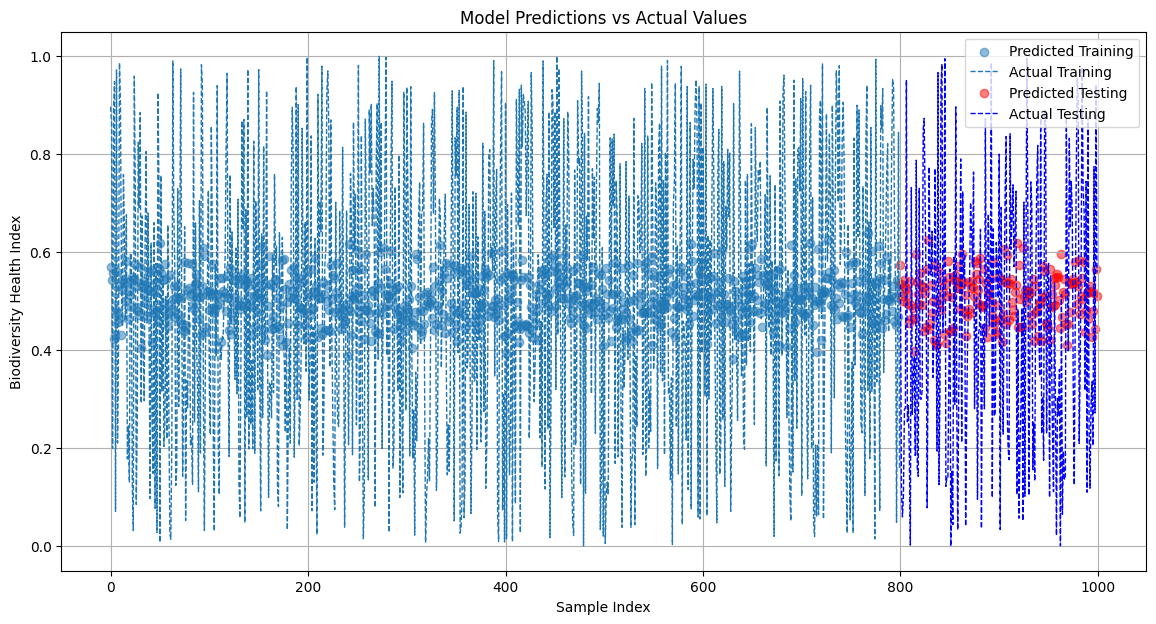

In [27]:
# Predictions
y_pred_train = ridge.predict(X_standardised.iloc[:len(y_train)])
y_pred_test = ridge.predict(X_standardised.iloc[len(y_train):])

plt.figure(figsize=(14, 7))  # Plot size

# Plot training predictions and actual values
plt.scatter(np.arange(len(y_train)), y_pred_train, label='Predicted Training', alpha=0.5)
plt.plot(np.arange(len(y_train)), y_train, label='Actual Training', linestyle='--', linewidth=1)

# Plot testing predictions and actual values
plt.scatter(np.arange(len(y_test)) + len(y_train), y_pred_test, label='Predicted Testing', alpha=0.5, color='red')
plt.plot(np.arange(len(y_test)) + len(y_train), y_test, label='Actual Testing', linestyle='--', linewidth=1, color='blue')

plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Biodiversity Health Index')
plt.grid(True)  # Add gridlines

plt.show()

The plot indicates that the Ridge regression model predicts both the training and testing data with moderate success, showing some alignment with the actual Biodiversity Health Index values. There is a consistent scatter across the range, suggesting the model's effectiveness in handling diverse data without significant overfitting. However, it is essential to continue assessing the model's performance, especially in the context of the MSE values discussed.

## Appendix

Links to additional resources to help with the understanding of concepts presented in the notebook.

- [Video on ridge regression by the authors of ISLR](https://www.youtube.com/watch?v=cSKzqb0EKS0)